In [1]:
import sys
sys.path.append('../')
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA as ARIMA_sm
from gtime.preprocessing import TimeSeriesPreparation
from gtime.time_series_models import ARIMA, AR
from sklearn.compose import make_column_selector
from gtime.feature_extraction import Shift
from sklearn.metrics import mean_squared_error
from scipy.stats import normaltest
import matplotlib.pyplot as plt
from gtime.stat_tools.mle_estimate import _run_css, _run_mle
%matplotlib inline  

## TIme series

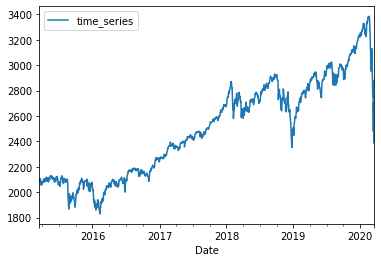

In [2]:
df_sp = pd.read_csv('https://storage.googleapis.com/l2f-open-models/giotto-time/examples/data/^GSPC.csv', parse_dates=['Date'])
df_close = df_sp.set_index('Date')['Close']
time_series_preparation = TimeSeriesPreparation()
df_real = time_series_preparation.transform(df_close)

df_real.plot();

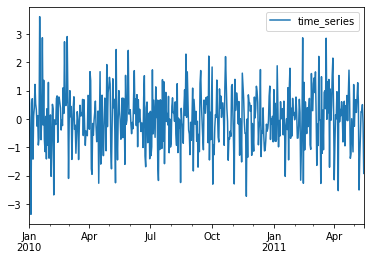

In [3]:
df_white = pd.DataFrame(np.random.standard_normal(500))
time_series_preparation = TimeSeriesPreparation(start='01-01-2010', freq='1D')
df_white = time_series_preparation.transform(df_white)

df_white.plot();

## Test functions

In [4]:
def train_test_plot(df_train, df_test, df_pred, train_error, test_error):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    df_train.plot(ax=ax[0])
    df_test.plot(ax=ax[0])
    df_pred.plot(ax=ax[0])
    ax[1].hist(train_error)
    ax[2].hist(test_error)

In [26]:
def run_giotto_ar(df, test_size, p):
    model = AR(horizon=test_size, p=p)
    df_train = df
    df_test = df.iloc[-test_size:]
    model = model.fit(df_train)
    pred_g = model.predict()
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    print('Basic AR results results:')
    print(f'Fitted parameters: mu={model.model.estimators_[0].intercept_:.2f}, p={model.model.estimators_[0].coef_}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
    return model.model.estimators_[0].coef_

mar = run_giotto_ar(df_white, 100, 4)
mar

Basic AR results results:
Fitted parameters: mu=0.01, p=[-0.05  0.01 -0.04 -0.01]
RMSE: 1.26



array([-0.05,  0.01, -0.04, -0.01])

Giotto results css:
Fitted parameters: mu=0.01, p=[-0.02 -0.05  0.01 -0.04], q=[]
AR roots abs:[2.3  2.3  2.15 2.15]
MA roots abs:[]
Train error mean: 0.00, std: 0.97
RMSE: 1.26



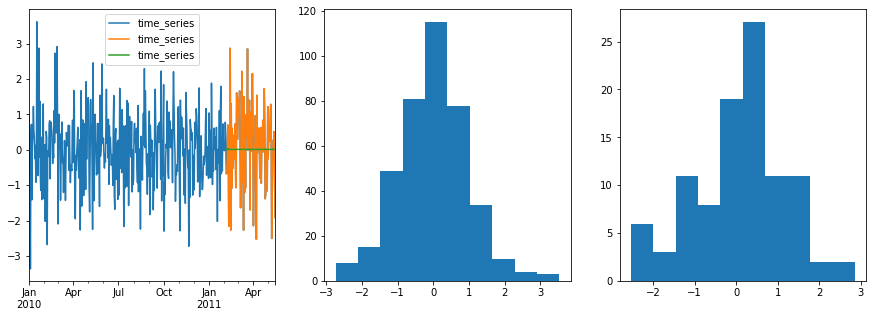

In [6]:
def run_giotto_arima(df, test_size, order, method='css-mle', plot=True):
    model = ARIMA(horizon=test_size, order=order, method=method)
    df_train = df
    df_test = df.iloc[-test_size:]
    model.fit(df_train)
    pred_g = model.predict(df_test.iloc[[0]])
    y_pred = pd.DataFrame(pred_g.values[0], index=df_test.index, columns=['time_series'])
    phi = model.model.params['phi'].values[0]
    theta = model.model.params['theta'].values[0]
    mu = model.model.params['mu'].values[0]
    train_errors = model.model.params['errors'].values[0]
    print(f'Giotto results {method}:')
    print(f'Fitted parameters: mu={mu:.2f}, p={phi}, q={theta}')
    print(f'AR roots abs:{np.abs(np.roots(np.r_[-phi[::-1], 1.0]))}')
    print(f'MA roots abs:{np.abs(np.roots(np.r_[theta[::-1], 1.0]))}')
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'RMSE: {mean_squared_error(y_pred, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test -  y_pred
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors.values)
    return mu, phi, theta
    
mu, phi, theta = run_giotto_arima(df_white, 100, (4, 0, 0), 'css')

Statsmodels results css:
Fitted parameters: mu=0.01, p=[-0.02 -0.05  0.01 -0.04], q=[]
AR roots abs:[2.15 2.15 2.3  2.3 ]
MA roots abs:[]
Train error mean: 0.00, std: 0.97
RMSE: 1.26



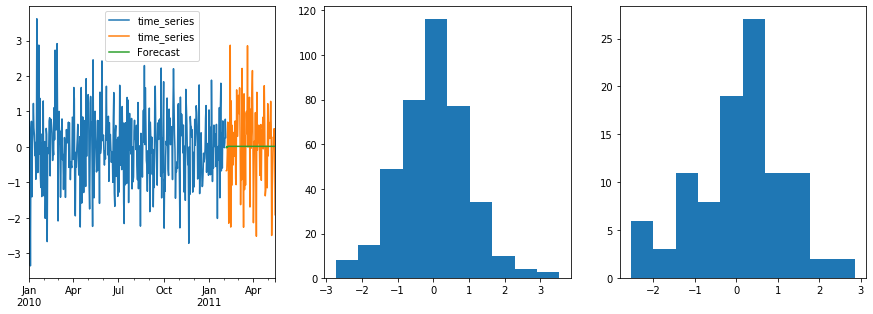

In [7]:
def run_sm(df, test_size, order, method='css-mle', plot=True):
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]
    m2 = ARIMA_sm(df_train, order)
    f = m2.fit(method=method)
    y2, _, _ = f.forecast(test_size)
    y_pred = pd.DataFrame(y2, index=df_test.index, columns=['Forecast'])
    print(f'Statsmodels results {method}:')
    print(f'Fitted parameters: mu={f.params.const:.2f}, p={f.arparams}, q={f.maparams}')
    print(f'AR roots abs:{np.abs(f.arroots)}')
    print(f'MA roots abs:{np.abs(f.maroots)}')
    train_errors = m2.geterrors(f.params)
    print(f'Train error mean: {train_errors.mean():.2f}, std: {train_errors.std():.2f}')
    print(f'RMSE: {mean_squared_error(y2, df_test.values):.2f}\n')
#     print(normaltest(train_errors))
    if plot:
        test_errors = df_test.values.flatten() -  y2
        train_test_plot(df_train, df_test, y_pred, train_errors, test_errors)
    return f, m2

f = run_sm(df_white, 100, (4, 0, 0), 'css')

## Simple AR check

In [27]:
df = df_white
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=0.01, p=[-0.05  0.01]
RMSE: 1.26

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.01 -0.05], q=[]
AR roots abs:[4.46 4.46]
MA roots abs:[]
Train error mean: 0.00, std: 0.98
RMSE: 1.26

Statsmodels results mle:
Fitted parameters: mu=0.01, p=[-0.01 -0.05], q=[]
AR roots abs:[4.46 4.46]
MA roots abs:[]
Train error mean: 0.00, std: 0.98
RMSE: 1.26

Giotto results css:
Fitted parameters: mu=0.00, p=[-0.01 -0.05], q=[]
AR roots abs:[4.4 4.4]
MA roots abs:[]
Train error mean: -0.00, std: 0.98
RMSE: 1.26



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.01, p=[-0.01 -0.05], q=[]
AR roots abs:[4.41 4.41]
MA roots abs:[]
Train error mean: -0.00, std: 0.98
RMSE: 1.26



In [29]:
df = df_real
run_giotto_ar(df, 100, 2)
run_sm(df, 100, (2, 0, 0), 'css', plot=False);
run_sm(df, 100, (2, 0, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 0, 0), 'mle', plot=False);

Basic AR results results:
Fitted parameters: mu=6.72, p=[0.92 0.07]
RMSE: 45435.50

Statsmodels results css:
Fitted parameters: mu=3261.40, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   49.74]
MA roots abs:[]
Train error mean: -0.02, std: 20.81
RMSE: 52639.91

Statsmodels results mle:
Fitted parameters: mu=2494.44, p=[0.98 0.02], q=[]
AR roots abs:[ 1.   53.84]
MA roots abs:[]
Train error mean: 0.37, std: 23.82
RMSE: 67607.63

Giotto results css:
Fitted parameters: mu=3154.03, p=[0.98 0.02], q=[]
AR roots abs:[49.65  1.  ]
MA roots abs:[]
Train error mean: -0.00, std: 20.80
RMSE: 51590.70



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=2442.61, p=[0.98 0.02], q=[]
AR roots abs:[53.65  1.  ]
MA roots abs:[]
Train error mean: 0.79, std: 20.79
RMSE: 65804.98



## Simple ARI check

In [49]:
df = df_white
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.00, p=[-0.65 -0.36], q=[]
AR roots abs:[1.67 1.67]
MA roots abs:[]
Train error mean: 0.00, std: 1.15
RMSE: 1.39

Statsmodels results mle:
Fitted parameters: mu=-0.00, p=[-0.65 -0.36], q=[]
AR roots abs:[1.67 1.67]
MA roots abs:[]
Train error mean: -0.00, std: 1.15
RMSE: 1.34

Giotto results css:
Fitted parameters: mu=-0.00, p=[-0.65 -0.36], q=[]
AR roots abs:[1.66 1.66]
MA roots abs:[]
Train error mean: 0.00, std: 1.14
RMSE: 1.30



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=-0.00, p=[-0.65 -0.36], q=[]
AR roots abs:[1.66 1.66]
MA roots abs:[]
Train error mean: -0.00, std: 1.14
RMSE: 1.34



In [51]:
df = df_real
run_sm(df, 100, (2, 1, 0), 'css', plot=False);
run_sm(df, 100, (2, 1, 0), 'mle', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'css', plot=False);
run_giotto_arima(df, 100, (2, 1, 0), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.78
RMSE: 46983.52

Statsmodels results mle:
Fitted parameters: mu=0.77, p=[-0.02 -0.06], q=[]
AR roots abs:[4.23 4.23]
MA roots abs:[]
Train error mean: 0.00, std: 20.77
RMSE: 46931.59

Giotto results css:
Fitted parameters: mu=0.78, p=[-0.02 -0.06], q=[]
AR roots abs:[4.24 4.24]
MA roots abs:[]
Train error mean: -0.00, std: 20.78
RMSE: 45009.66



../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.78, p=[-0.02 -0.06], q=[]
AR roots abs:[4.24 4.24]
MA roots abs:[]
Train error mean: 0.01, std: 20.76
RMSE: 44964.31



## Simple MA

In [55]:
%prun run_giotto_arima(df_real, 100, (2, 1, 3), 'mle', plot=False);

../gtime/stat_tools/tools.py:7: RuntimeWarning: overflow encountered in multiply
  return -0.5 * (np.log(2 * np.pi * np.abs(F)) + mat_square(np.linalg.inv(F), nu))


Giotto results mle:
Fitted parameters: mu=0.78, p=[-0.99 -0.92], q=[ 0.97  0.87 -0.04]
AR roots abs:[1.04 1.04]
MA roots abs:[25.85  1.05  1.05]
Train error mean: 0.01, std: 20.71
RMSE: 44664.63

 

In [53]:
df = df_white
run_sm(df, 100, (0, 0, 3), 'css', plot=False);
run_sm(df, 100, (0, 0, 3), 'mle', plot=False);
run_giotto_arima(df, 100, (0, 0, 3), 'css', plot=False);
run_giotto_arima(df, 100, (0, 0, 3), 'mle', plot=False);

Statsmodels results css:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[3.75 6.16 8.75]
Train error mean: 0.00, std: 0.98
RMSE: 1.26

Statsmodels results mle:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[3.75 6.27 8.54]
Train error mean: 0.00, std: 0.98
RMSE: 1.26



../gtime/stat_tools/mle_estimate.py:59: RuntimeWarning: invalid value encountered in double_scalars
  loglikelihood = -nobs / 2. * (np.log(2 * np.pi * sigma2)) - ssr / (2. * sigma2)


Giotto results css:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[10.56  5.48  3.75]
Train error mean: 0.00, std: 0.98
RMSE: 1.26

Giotto results mle:
Fitted parameters: mu=0.01, p=[], q=[-0.01 -0.06  0.  ]
AR roots abs:[]
MA roots abs:[10.03  5.62  3.74]
Train error mean: -0.00, std: 0.98
RMSE: 1.26

